In [1]:
import keras
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D, Dropout,\
                         Activation, Flatten, MaxPooling2D, UpSampling2D, SimpleRNN, Embedding, LSTM
from keras.datasets import fashion_mnist
from keras.applications import VGG16
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import io
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1 Autoencoder

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print x_train.shape

(60000, 28, 28, 1)


In [3]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.3238 - val_loss: 0.3166
Epoch 2/10
60000/60000 [==============================] - 137s 2ms/step - loss: 0.3071 - val_loss: 0.3050
Epoch 3/10
60000/60000 [==============================] - 130s 2ms/step - loss: 0.3006 - val_loss: 0.2993
Epoch 4/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.2958 - val_loss: 0.2957
Epoch 5/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.2929 - val_loss: 0.2935
Epoch 6/10
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2906 - val_loss: 0.2901
Epoch 7/10
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2886 - val_loss: 0.2897
Epoch 8/10
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2866 - val_loss: 0.2885
Epoch 9/10
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2856 - val_loss: 0.2

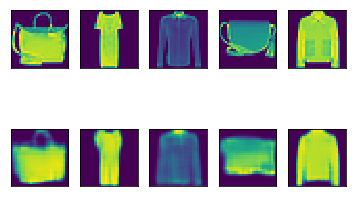

In [8]:
decoded_imgs = autoencoder.predict(x_test)
f, ax = plt.subplots(2, 5)
for i in range(5):
    r = np.random.randint(1,1000)
    ax[0,i].imshow(x_test[r].reshape(28, 28))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    ax[1,i].imshow(decoded_imgs[r].reshape(28, 28))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

## 2 Image Classification

### 2.1 Deep CNN

In [9]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#### I stacked two 2d convolutional layers with small kernel size for better learning ability. I chose zero padding to preserve the spatial size. Adding pooling layer and dropout layer could reduce dimension and force the model to learn. The dataset is small and easy to classify, thus the model is not too deep. After flatten, simply 2 dense layers could achieve a good multi-class classification result. 

In [10]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [11]:
model.fit(x_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.5270 - acc: 0.8124 - val_loss: 0.3421 - val_acc: 0.8751
Epoch 2/10
60000/60000 [==============================] - 171s 3ms/step - loss: 0.3228 - acc: 0.8841 - val_loss: 0.2823 - val_acc: 0.8946
Epoch 3/10
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2745 - acc: 0.8994 - val_loss: 0.2597 - val_acc: 0.9033
Epoch 4/10
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2458 - acc: 0.9100 - val_loss: 0.2408 - val_acc: 0.9118
Epoch 5/10
60000/60000 [==============================] - 172s 3ms/step - loss: 0.2206 - acc: 0.9187 - val_loss: 0.2270 - val_acc: 0.9184
Epoch 6/10
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2057 - acc: 0.9235 - val_loss: 0.2245 - val_acc: 0.9199
Epoch 7/10
60000/60000 [==============================] - 172s 3ms/step - loss: 0.1835 - acc: 0.9328 - val_loss: 0.2148 - 

In [12]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Loss Value for training set:', score[0]) 
print('Accuracy for training set:', score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss Value for test set:', score[0]) 
print('Accuracy for test set:', score[1])

('Loss Value for training set:', 0.09601795230507851)
('Accuracy for training set:', 0.9664)
('Loss Value for test set:', 0.21263476656377314)
('Accuracy for test set:', 0.9274)


### 2.2 Transfer Learning

In [14]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.asarray([cv2.resize(i, (32,32)) for i in x_train])
x_test = np.asarray([cv2.resize(i, (32,32)) for i in x_test])
x_train = x_train.reshape(x_train.shape[0], 32, 32,1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)
x_train = np.dstack([x_train] * 3)
x_test = np.dstack([x_test]*3)
x_train = x_train.reshape(-1, 32,32,3)
x_test= x_test.reshape (-1,32,32,3)

y_train = keras.utils.to_categorical(y_train, 10) 
y_test = keras.utils.to_categorical(y_test, 10)

#### I used the pre-trained model VGG16 as the base model, freeze the layers and add 3 dense layers for classification.

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
for layer in base_model.layers:
    layer.trainable = False

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [16]:
model.fit(x_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 481s 8ms/step - loss: 2.8291 - acc: 0.5144 - val_loss: 0.8288 - val_acc: 0.7174
Epoch 2/10
60000/60000 [==============================] - 494s 8ms/step - loss: 0.9478 - acc: 0.6705 - val_loss: 0.6696 - val_acc: 0.7641
Epoch 3/10
60000/60000 [==============================] - 500s 8ms/step - loss: 0.8181 - acc: 0.7077 - val_loss: 0.6407 - val_acc: 0.7704
Epoch 4/10
60000/60000 [==============================] - 496s 8ms/step - loss: 0.7494 - acc: 0.7310 - val_loss: 0.5916 - val_acc: 0.7886
Epoch 5/10
60000/60000 [==============================] - 496s 8ms/step - loss: 0.7085 - acc: 0.7448 - val_loss: 0.5718 - val_acc: 0.7934
Epoch 6/10
60000/60000 [==============================] - 501s 8ms/step - loss: 0.6747 - acc: 0.7569 - val_loss: 0.5532 - val_acc: 0.7979
Epoch 7/10
60000/60000 [==============================] - 480s 8ms/step - loss: 0.6474 - acc: 0.7667 - val_loss: 0.5424 - 

In [18]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Loss Value for training set:', score[0]) 
print('Accuracy for training set:', score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss Value for test set:', score[0]) 
print('Accuracy for test set:', score[1])

('Loss Value for training set:', 0.47049360126654305)
('Accuracy for training set:', 0.8254833333333333)
('Loss Value for test set:', 0.5183112221717835)
('Accuracy for test set:', 0.8146)


## 3 Text Classification
### 3.1 RNN 

In [34]:
benign = get_file('benign', origin='https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt')
malicious = get_file('malicious', origin='https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt')

with io.open(benign, encoding='utf-8') as f:
    lines = f.readlines()
benign_string = [line.rstrip("\n\r") for line in lines[0:] if "#" not in line]

with io.open(malicious, encoding='utf-8') as f:
    lines = f.readlines()
malicious_string = [line.rstrip("\n\r") for line in lines[0:] if "#" not in line]

benign_urls = pd.DataFrame(benign_string)
benign_urls['label'] = 1

malicious_urls = pd.DataFrame(malicious_string)
malicious_urls['label'] = 0

df = pd.concat([benign_urls, malicious_urls])
df.columns = ['urls', 'label']
df.head(5)

,urls,label
0,.0.blogger.gmodules.com,1
1,.0.client-channel.google.com,1
2,.0.docs.google.com,1
3,.0.drive.google.com,1
4,.0.gvt0.cn,1


In [35]:
tokenizer = Tokenizer(num_words = 100000)
tokenizer.fit_on_texts(df['urls'])
seq = tokenizer.texts_to_sequences(df['urls'])

max_len = max(df['urls'].str.len())
X = pad_sequences(seq, maxlen=max_len)

X_train, X_test, Y_train, Y_test = train_test_split(X, np.array(df.label), test_size=0.2, random_state=123)

In [21]:
model = Sequential()
model.add(Embedding(100000, 64))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 64, validation_data = (X_test,Y_test), verbose=1)

Train on 53848 samples, validate on 13463 samples
Epoch 1/10
53848/53848 [==============================] - 141s 3ms/step - loss: 0.0581 - acc: 0.9847 - val_loss: 0.0194 - val_acc: 0.9913
Epoch 2/10
53848/53848 [==============================] - 140s 3ms/step - loss: 0.0114 - acc: 0.9957 - val_loss: 0.0228 - val_acc: 0.9847
Epoch 3/10
53848/53848 [==============================] - 139s 3ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0209 - val_acc: 0.9921
Epoch 4/10
53848/53848 [==============================] - 139s 3ms/step - loss: 8.2364e-04 - acc: 0.9999 - val_loss: 0.0207 - val_acc: 0.9921
Epoch 5/10
53848/53848 [==============================] - 139s 3ms/step - loss: 6.1453e-04 - acc: 0.9999 - val_loss: 0.0196 - val_acc: 0.9926
Epoch 6/10
53848/53848 [==============================] - 143s 3ms/step - loss: 4.2618e-04 - acc: 0.9999 - val_loss: 0.0238 - val_acc: 0.9923
Epoch 7/10
53848/53848 [==============================] - 141s 3ms/step - loss: 2.5509e-04 - acc: 0.9999 - val

In [23]:
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_rnn = auc(fpr, tpr)

### 3.2 CNN

In [29]:
model = Sequential()
model.add(Embedding(100000, 128, input_length=max_len))
model.add(Dropout(0.2))
model.add(Conv1D(128, 4, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 86, 128)           12800000  
_________________________________________________________________
dropout_8 (Dropout)          (None, 86, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 83, 128)           65664     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 12,865,793
Trainable params: 12,865,793
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_log = model.fit(X_train, Y_train, epochs = 10, batch_size = 64, validation_data = (X_test,Y_test), verbose=1)

Train on 53848 samples, validate on 13463 samples
Epoch 1/10
53848/53848 [==============================] - 192s 4ms/step - loss: 0.0484 - acc: 0.9855 - val_loss: 0.0184 - val_acc: 0.9919
Epoch 2/10
53848/53848 [==============================] - 190s 4ms/step - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0168 - val_acc: 0.9927
Epoch 3/10
53848/53848 [==============================] - 192s 4ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0175 - val_acc: 0.9912
Epoch 4/10
53848/53848 [==============================] - 192s 4ms/step - loss: 3.6410e-04 - acc: 0.9999 - val_loss: 0.0196 - val_acc: 0.9887
Epoch 5/10
53848/53848 [==============================] - 192s 4ms/step - loss: 1.6606e-04 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 0.9892
Epoch 6/10
53848/53848 [==============================] - 195s 4ms/step - loss: 1.1537e-04 - acc: 0.9999 - val_loss: 0.0186 - val_acc: 0.9915
Epoch 7/10
53848/53848 [==============================] - 206s 4ms/step - loss: 8.6027e-05 - acc: 1.0000 - val

In [31]:
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_cnn = auc(fpr, tpr)

## 3.3 Plot ROC

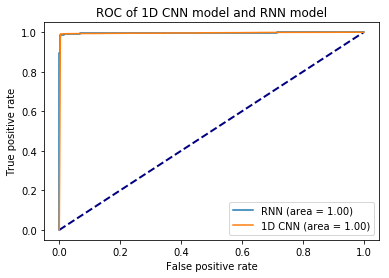

In [32]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC of 1D CNN model and RNN model')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = %0.2f)'% auc_rnn)
plt.plot(fpr_cnn, tpr_cnn, label='1D CNN (area = %0.2f)'% auc_cnn)
plt.legend(loc='best')
plt.show()